Загрузка данных...
Загружено 300 образцов
Распределение классов: [100 100 100]
Размер обучающей выборки: (240, 299)
Размер тестовой выборки: (60, 299)

=== Обучение CatBoost ===
0:	learn: 1.0761462	total: 18ms	remaining: 5.39s
1:	learn: 1.0626008	total: 26.7ms	remaining: 3.98s
2:	learn: 1.0418021	total: 35.5ms	remaining: 3.51s
3:	learn: 1.0281931	total: 45.1ms	remaining: 3.34s
4:	learn: 1.0148270	total: 53.8ms	remaining: 3.17s
5:	learn: 1.0025187	total: 63.4ms	remaining: 3.11s
6:	learn: 0.9928716	total: 71.7ms	remaining: 3s
7:	learn: 0.9833570	total: 81.1ms	remaining: 2.96s
8:	learn: 0.9758770	total: 90.8ms	remaining: 2.94s
9:	learn: 0.9649915	total: 100ms	remaining: 2.91s
10:	learn: 0.9572545	total: 110ms	remaining: 2.88s
11:	learn: 0.9469952	total: 119ms	remaining: 2.85s
12:	learn: 0.9387475	total: 129ms	remaining: 2.85s
13:	learn: 0.9309005	total: 138ms	remaining: 2.81s
14:	learn: 0.9246179	total: 147ms	remaining: 2.79s
15:	learn: 0.9218378	total: 156ms	remaining: 2.76s
16:	learn: 0

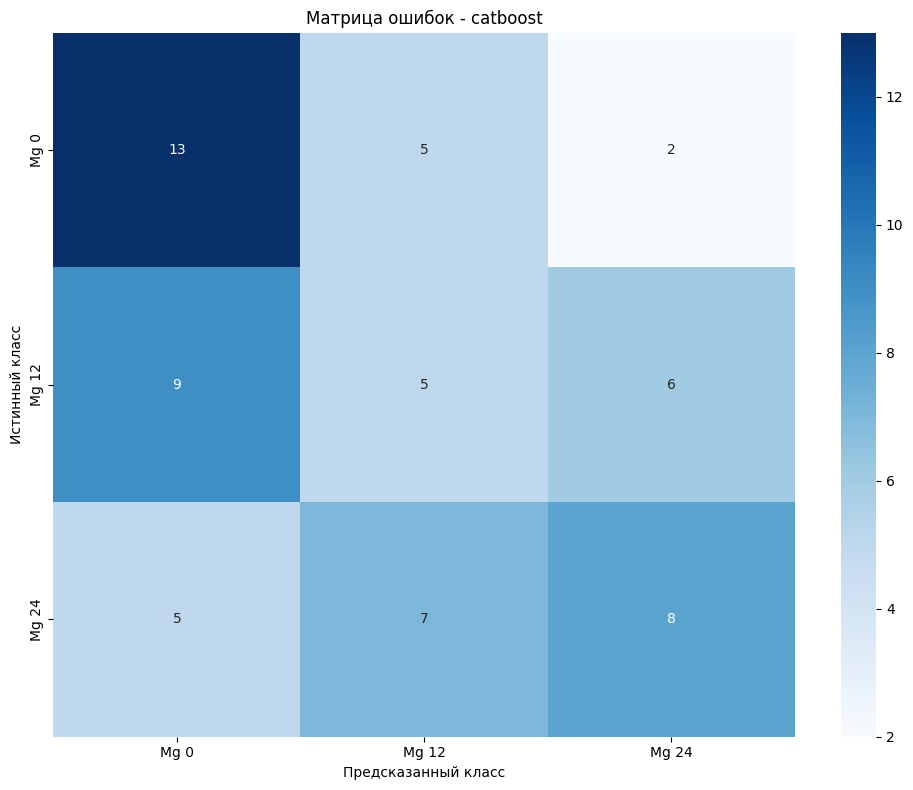


=== Подбор гиперпараметров для CatBoost ===
Fitting 2 folds for each of 5 candidates, totalling 10 fits

Поиск завершен за 186.42 сек.
Лучшие параметры: {'learning_rate': 0.2, 'iterations': 100, 'depth': 4}
Лучший результат: 0.5033

Точность настроенной модели на тестовой выборке: 0.4333


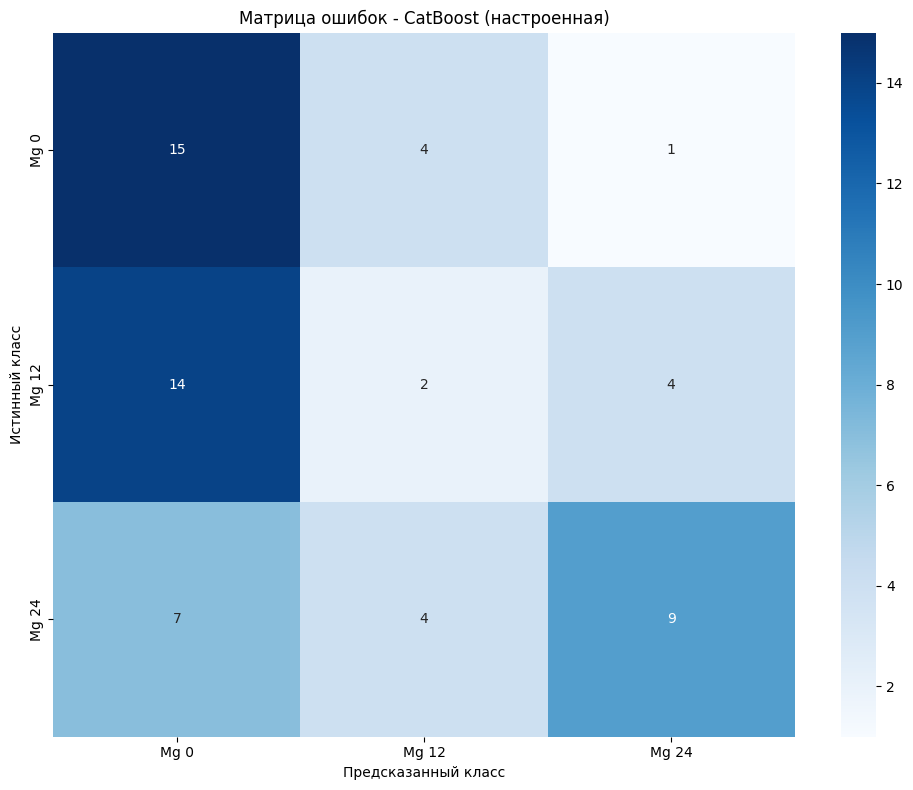


=== Feature Importance для catboost_tuned ===


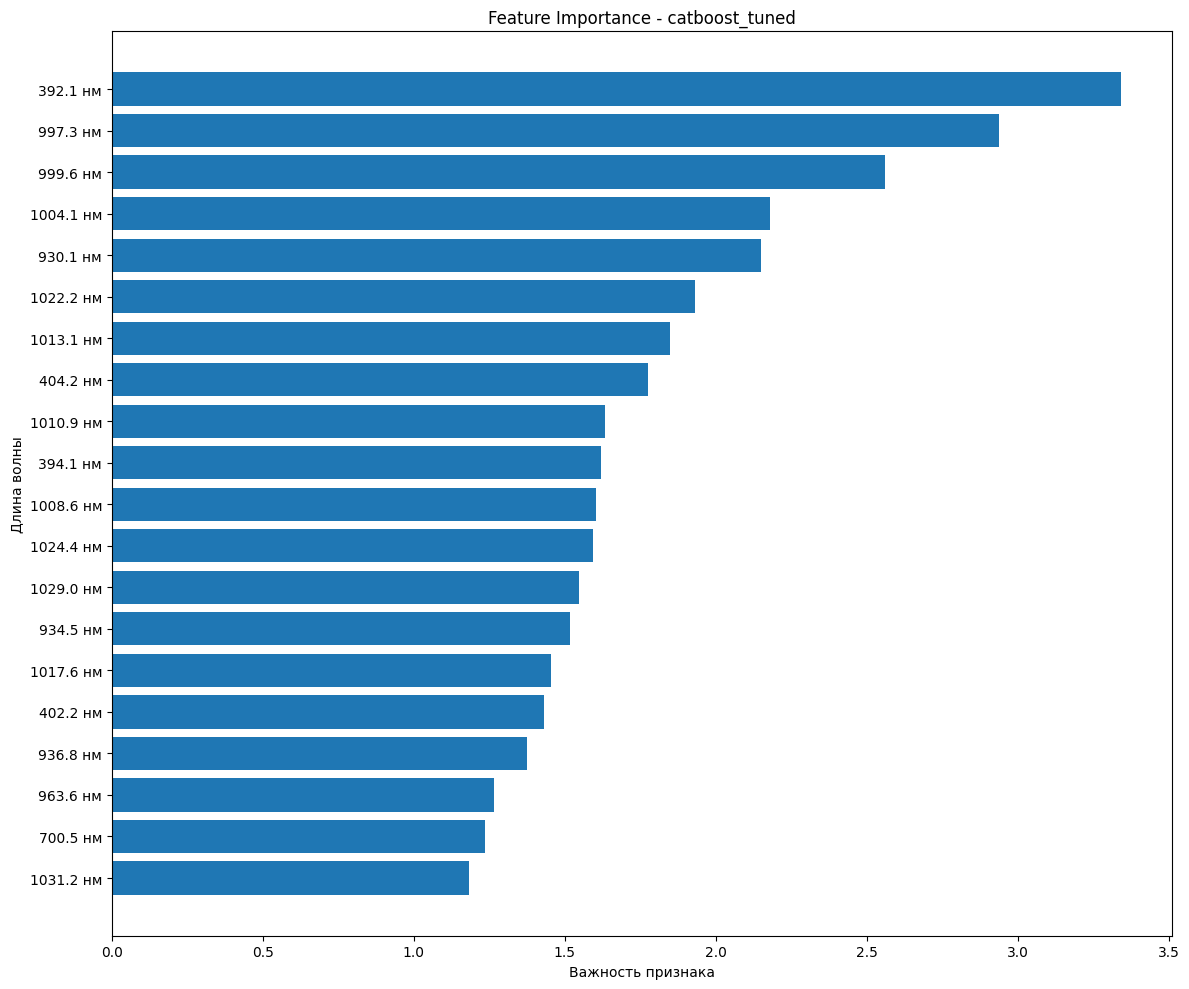


Топ-20 важных длин волн:
1. 392.1 нм: 3.3438
2. 997.3 нм: 2.9379
3. 999.6 нм: 2.5611
4. 1004.1 нм: 2.1785
5. 930.1 нм: 2.1513
6. 1022.2 нм: 1.9320
7. 1013.1 нм: 1.8486
8. 404.2 нм: 1.7756
9. 1010.9 нм: 1.6329
10. 394.1 нм: 1.6192
11. 1008.6 нм: 1.6051
12. 1024.4 нм: 1.5933
13. 1029.0 нм: 1.5466
14. 934.5 нм: 1.5158
15. 1017.6 нм: 1.4555
16. 402.2 нм: 1.4306
17. 936.8 нм: 1.3740
18. 963.6 нм: 1.2643
19. 700.5 нм: 1.2362
20. 1031.2 нм: 1.1834


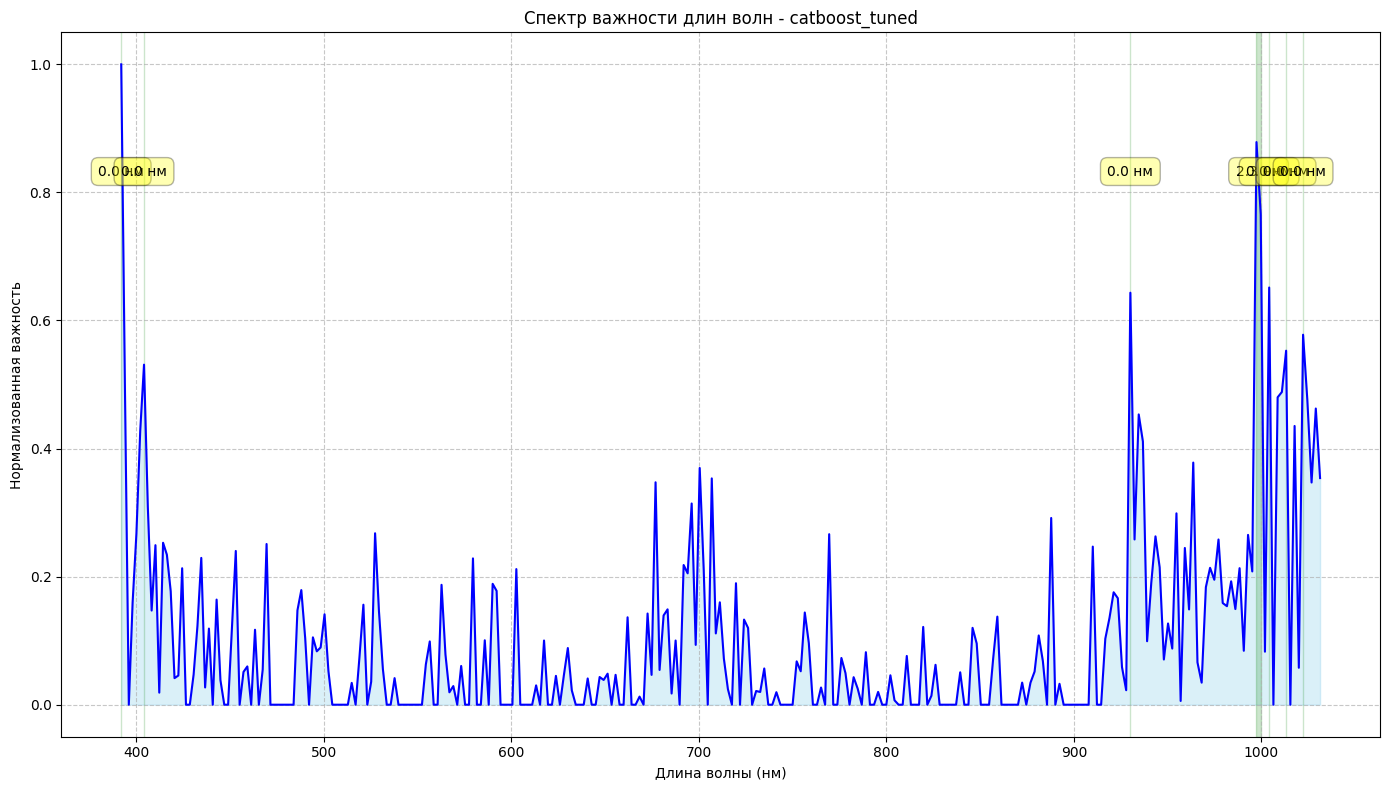


=== Кросс-валидация для catboost ===
Количество фолдов: 5
Средняя точность: 0.4733 ± 0.0429
Минимальная точность: 0.4000
Максимальная точность: 0.5333


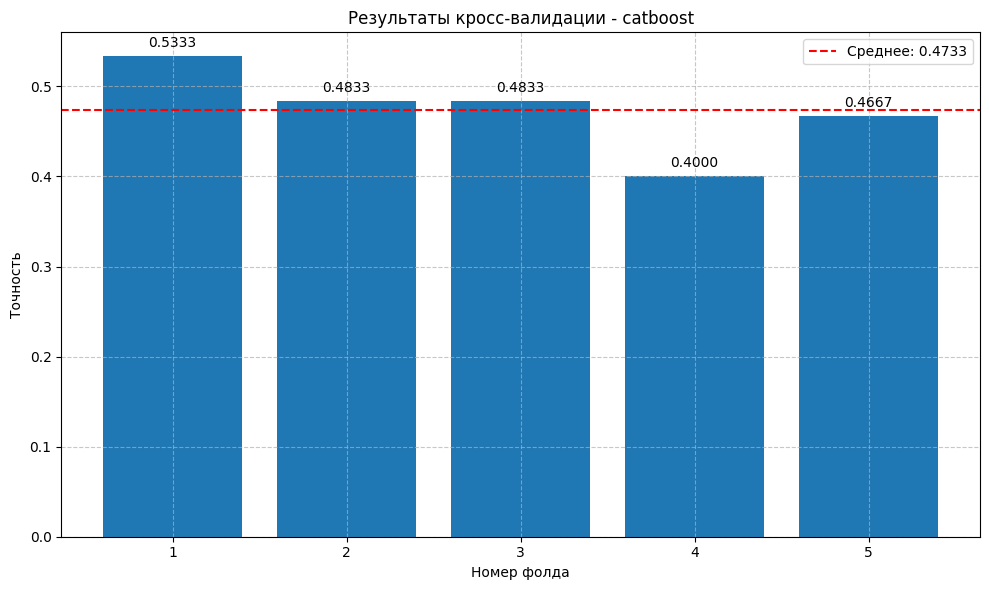


Анализ завершен!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

# Только для CatBoost
import catboost as cb

# Для визуализации
from matplotlib import cm
from sklearn.inspection import permutation_importance

# Функция для загрузки данных
def load_data_from_excel(file_path):
    """Загрузка данных из Excel-файла с тремя листами."""
    # Списки для хранения данных
    all_spectra = []
    all_labels = []
    wavelengths = None
    
    # Уровни магния соответствующие листам
    mg_levels = [0, 12, 24]
    
    # Чтение каждого листа
    for sheet_idx, sheet_name in enumerate(['Mg0', 'Mg1', 'Mg2']):
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        
        # Получаем длины волн из первого столбца (начиная со 2-й строки)
        if wavelengths is None:
            wavelengths = df.iloc[1:, 0].values
        
        # Для каждого земельного участка (каждый столбец, начиная со 2-го)
        for col_idx in range(1, df.shape[1]):
            # Получаем спектральные данные для этого участка
            spectrum = df.iloc[1:, col_idx].values
            
            # Пропускаем, если есть отсутствующие данные
            if not np.isnan(spectrum).any():
                all_spectra.append(spectrum)
                # Уровень магния соответствует листу
                all_labels.append(mg_levels[sheet_idx])
    
    # Преобразуем в массивы numpy
    X = np.array(all_spectra)
    y = np.array(all_labels)
    
    return X, y, wavelengths

# Класс для обучения и оценки CatBoost
class GradientBoostingAnalysis:
    def __init__(self, X, y, wavelengths, mg_levels, test_size=0.2, random_state=42):
        """Инициализация с данными и параметрами."""
        self.X = X
        self.y = y
        self.wavelengths = wavelengths
        self.mg_levels = mg_levels
        self.test_size = test_size
        self.random_state = random_state
        
        # Подготовка данных
        self.prepare_data()
        
        # Словарь для моделей
        self.models = {}
        self.results = {}
        
    def prepare_data(self):
        """Подготовка данных: масштабирование и разделение на обучающую и тестовую выборки."""
        # Нормализация данных
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)
        
        # Разделение на обучающую и тестовую выборки
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_scaled, self.y, 
            test_size=self.test_size, 
            stratify=self.y, 
            random_state=self.random_state
        )
        
        print(f"Размер обучающей выборки: {self.X_train.shape}")
        print(f"Размер тестовой выборки: {self.X_test.shape}")
        
    def train_catboost(self, params=None, verbose=True):
        """Обучение модели CatBoost."""
        print("\n=== Обучение CatBoost ===")
        start_time = time.time()
        
        # Создание отображения классов в индексы
        class_map = {val: idx for idx, val in enumerate(self.mg_levels)}
        y_train_mapped = np.array([class_map[y] for y in self.y_train])
        
        # Параметры по умолчанию
        default_params = {
            'loss_function': 'MultiClass',
            'iterations': 300,
            'depth': 3,
            'learning_rate': 0.1,
            'random_seed': self.random_state,
            'verbose': verbose,
            'classes_count': len(self.mg_levels)  # Явно указываем количество классов
        }
        
        # Объединяем с переданными параметрами
        if params:
            default_params.update(params)
        
        # Создание и обучение модели
        model = cb.CatBoostClassifier(**default_params)
        
        # Обучение с правильно отображенными классами
        model.fit(self.X_train, y_train_mapped)
        
        # Сохраняем модель и отображение классов
        self.models['catboost'] = model
        self.class_map = class_map
        
        # Оценка модели
        train_time = time.time() - start_time
        self._evaluate_model('catboost', train_time)
        
        return model
        
    def _evaluate_model(self, model_name, train_time):
        """Оценка модели на тестовых данных."""
        model = self.models[model_name]
        
        # Отображение тестовых меток в индексы для корректного сравнения
        class_map = {val: idx for idx, val in enumerate(self.mg_levels)}
        y_test_mapped = np.array([class_map[y] for y in self.y_test])
        
        # Получаем прогнозированные индексы классов
        y_pred_indices = model.predict(self.X_test)
        y_pred_indices = y_pred_indices.astype(int).flatten()
        
        # Обратное отображение в исходные значения классов
        reverse_map = {idx: val for val, idx in class_map.items()}
        y_pred = np.array([reverse_map[idx] for idx in y_pred_indices])
        
        # Расчет точности используя отображенные индексы
        accuracy = accuracy_score(y_test_mapped, y_pred_indices)
        
        # Сохраняем результаты
        self.results[model_name] = {
            'accuracy': accuracy,
            'predictions': y_pred,
            'train_time': train_time
        }
        
        # Вывод результатов
        print(f"\nМодель: {model_name}")
        print(f"Точность: {accuracy:.4f}")
        print(f"Время обучения: {train_time:.2f} сек.")
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred))
        
        # Матрица ошибок
        cm = confusion_matrix(self.y_test, y_pred)
        print("Confusion Matrix:")
        print(cm)
        
        # Визуализация матрицы ошибок
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=[f'Mg {level}' for level in self.mg_levels],
                   yticklabels=[f'Mg {level}' for level in self.mg_levels])
        plt.title(f'Матрица ошибок - {model_name}')
        plt.xlabel('Предсказанный класс')
        plt.ylabel('Истинный класс')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{model_name}.png')
        plt.show()
        
    def cross_validate(self, model_type='catboost', n_folds=5, params=None):
        """Проведение кросс-валидации для выбранной модели."""
        print(f"\n=== Кросс-валидация для {model_type} ===")
        
        # Параметры по умолчанию для модели
        default_params = {
            'loss_function': 'MultiClass',
            'iterations': 100,
            'depth': 5,
            'learning_rate': 0.1,
            'random_seed': self.random_state,
            'verbose': False
        }
        
        # Объединяем с переданными параметрами
        if params:
            default_params.update(params)
        
        # Создание модели
        model = cb.CatBoostClassifier(**default_params)
        
        # Проведение кросс-валидации
        cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=self.random_state)
        scores = cross_val_score(model, self.X, self.y, cv=cv, scoring='accuracy')
        
        print(f"Количество фолдов: {n_folds}")
        print(f"Средняя точность: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
        print(f"Минимальная точность: {np.min(scores):.4f}")
        print(f"Максимальная точность: {np.max(scores):.4f}")
        
        # Визуализация результатов
        plt.figure(figsize=(10, 6))
        plt.bar(range(1, n_folds+1), scores)
        plt.axhline(y=np.mean(scores), color='r', linestyle='--', 
                   label=f'Среднее: {np.mean(scores):.4f}')
        
        for i, score in enumerate(scores):
            plt.text(i+1, score+0.01, f'{score:.4f}', ha='center')
        
        plt.xlabel('Номер фолда')
        plt.ylabel('Точность')
        plt.title(f'Результаты кросс-валидации - {model_type}')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f'cross_validation_{model_type}.png')
        plt.show()
        
        return scores
        
    def hyperparameter_tuning(self, param_grid=None):
        """Подбор гиперпараметров для CatBoost."""
        print(f"\n=== Подбор гиперпараметров для CatBoost ===")
        
        # Используем RandomizedSearchCV вместо GridSearchCV
        from sklearn.model_selection import RandomizedSearchCV
        
        # Более компактная сетка параметров
        default_param_grid = {
            'depth': [4, 6],
            'learning_rate': [0.05, 0.1],
            'iterations': [100]
        }
        
        # Используем переданную сетку параметров, если она есть
        if param_grid:
            grid = param_grid
        else:
            grid = default_param_grid
        
        # Базовые параметры для CatBoost с явными настройками для экономии памяти
        base_params = {
            'loss_function': 'MultiClass',
            'random_seed': self.random_state,
            'verbose': False,
            'task_type': 'CPU',  # Явно указываем CPU
            'bootstrap_type': 'Bernoulli',  # Меньшее использование памяти
            'subsample': 0.8  # Используем только 80% данных для каждого дерева
        }
        
        # Создание модели
        model = cb.CatBoostClassifier(**base_params)
        
        # Сокращаем количество фолдов и ограничиваем количество комбинаций
        cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=self.random_state)
        
        search = RandomizedSearchCV(
            model, grid, cv=cv, scoring='accuracy', 
            n_jobs=1,  # Устанавливаем n_jobs=1 для снижения потребления памяти
            verbose=1, n_iter=5  # Пробуем только 5 комбинаций
        )
        
        # Поиск оптимальных параметров
        start_time = time.time()
        search.fit(self.X, self.y)
        search_time = time.time() - start_time
        

        
        print(f"\nПоиск завершен за {search_time:.2f} сек.")
        print(f"Лучшие параметры: {search.best_params_}")
        print(f"Лучший результат: {search.best_score_:.4f}")
        
        # Обучаем лучшую модель на всех данных
        best_model = search.best_estimator_
        self.models['catboost_tuned'] = best_model
        
        # Предсказания на тестовой выборке
        y_pred = best_model.predict(self.X_test)
        y_pred = y_pred.astype(int).flatten()
        accuracy = accuracy_score(self.y_test, y_pred)
        
        print(f"\nТочность настроенной модели на тестовой выборке: {accuracy:.4f}")
        
        # Сохраняем результаты
        train_time = search_time
        self.results['catboost_tuned'] = {
            'accuracy': accuracy,
            'predictions': y_pred,
            'train_time': train_time
        }
        
        # Оценка и визуализация результатов
        cm = confusion_matrix(self.y_test, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=[f'Mg {level}' for level in self.mg_levels],
                   yticklabels=[f'Mg {level}' for level in self.mg_levels])
        plt.title(f'Матрица ошибок - CatBoost (настроенная)')
        plt.xlabel('Предсказанный класс')
        plt.ylabel('Истинный класс')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_catboost_tuned.png')
        plt.show()
        
        return best_model, search.best_params_
        
    def plot_feature_importance(self, model_name='catboost', top_n=20, use_permutation=False):
        """Визуализация важности признаков."""
        model = self.models[model_name]
        
        plt.figure(figsize=(12, 10))
        
        if use_permutation:
            # Используем permutation importance
            print(f"\n=== Permutation Importance для {model_name} ===")
            result = permutation_importance(
                model, self.X_test, self.y_test, n_repeats=10, random_state=self.random_state
            )
            
            # Сортировка признаков по важности
            indices = np.argsort(result.importances_mean)[-top_n:]
            importances = result.importances_mean[indices]
            
            # Визуализация
            plt.barh(range(len(indices)), importances, align='center')
            plt.yticks(range(len(indices)), [f"{self.wavelengths[i]:.1f} нм" for i in indices])
            plt.title(f'Permutation Feature Importance - {model_name}')
            
        else:
            # Встроенная важность признаков
            print(f"\n=== Feature Importance для {model_name} ===")
            
            # Получаем важность признаков
            importances = model.get_feature_importance()
            
            # Сортировка признаков по важности
            indices = np.argsort(importances)[-top_n:]
            
            # Визуализация
            plt.barh(range(len(indices)), importances[indices], align='center')
            plt.yticks(range(len(indices)), [f"{self.wavelengths[i]:.1f} нм" for i in indices])
            plt.title(f'Feature Importance - {model_name}')
        
        plt.xlabel('Важность признака')
        plt.ylabel('Длина волны')
        plt.tight_layout()
        plt.savefig(f'feature_importance_{model_name}.png')
        plt.show()
        
        # Вывод наиболее важных признаков
        print(f"\nТоп-{top_n} важных длин волн:")
        for i, idx in enumerate(indices[::-1]):
            if use_permutation:
                importance = result.importances_mean[idx]
                std = result.importances_std[idx]
                print(f"{i+1}. {self.wavelengths[idx]:.1f} нм: {importance:.4f} ± {std:.4f}")
            else:
                importance = importances[idx]
                print(f"{i+1}. {self.wavelengths[idx]:.1f} нм: {importance:.4f}")
    
    def plot_wavelength_importance_spectrum(self, model_name='catboost', use_permutation=False):
        """Визуализация важности признаков в контексте спектра."""
        model = self.models[model_name]
        
        plt.figure(figsize=(14, 8))
        
        if use_permutation:
            # Используем permutation importance
            result = permutation_importance(
                model, self.X_test, self.y_test, n_repeats=10, random_state=self.random_state
            )
            importances = result.importances_mean
        else:
            # Встроенная важность признаков
            importances = model.get_feature_importance()
        
        # Сортировка длин волн
        sorted_idx = np.argsort(self.wavelengths)
        sorted_wavelengths = self.wavelengths[sorted_idx]
        sorted_importances = importances[sorted_idx]
        
        # Нормализация важности для визуализации
        normalized_importances = sorted_importances / sorted_importances.max()
        
        # Построение графика
        plt.plot(sorted_wavelengths, normalized_importances, 'b-')
        plt.fill_between(sorted_wavelengths, normalized_importances, alpha=0.3, color='skyblue')
        
        # Отметка наиболее важных диапазонов
        threshold = 0.5  # Порог для выделения важных диапазонов
        important_mask = normalized_importances > threshold
        
        # Выделение и аннотирование важных диапазонов
        in_range = False
        start_idx = 0
        
        for i in range(len(important_mask)):
            if important_mask[i] and not in_range:
                # Начало нового важного диапазона
                in_range = True
                start_idx = i
            elif not important_mask[i] and in_range:
                # Конец важного диапазона
                in_range = False
                end_idx = i - 1
                
                # Выделяем диапазон
                start_wl = sorted_wavelengths[start_idx]
                end_wl = sorted_wavelengths[end_idx]
                plt.axvspan(start_wl, end_wl, alpha=0.2, color='green')
                
                # Добавляем аннотацию
                mid_point = (start_wl + end_wl) / 2
                width = end_wl - start_wl
                plt.annotate(f"{width:.1f} нм", xy=(mid_point, 0.8), 
                            xytext=(0, 10), textcoords='offset points',
                            ha='center', va='bottom',
                            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))
        
        # Если последний диапазон важен
        if in_range:
            start_wl = sorted_wavelengths[start_idx]
            end_wl = sorted_wavelengths[-1]
            plt.axvspan(start_wl, end_wl, alpha=0.2, color='green')
            
            mid_point = (start_wl + end_wl) / 2
            width = end_wl - start_wl
            plt.annotate(f"{width:.1f} нм", xy=(mid_point, 0.8), 
                         xytext=(0, 10), textcoords='offset points',
                         ha='center', va='bottom',
                         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))
        
        plt.xlabel('Длина волны (нм)')
        plt.ylabel('Нормализованная важность')
        plt.title(f'Спектр важности длин волн - {model_name}')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f'wavelength_importance_spectrum_{model_name}.png')
        plt.show()
        
    def train_model(self):
        """Обучение модели CatBoost."""
        return self.train_catboost()

def main():
    # Путь к файлу с данными
    file_path = 'datamg100.xlsx'  # Замените на ваш путь к файлу
    
    # Уровни магния
    mg_levels = [0, 12, 24]
    
    # Загрузка данных
    print("Загрузка данных...")
    X, y, wavelengths = load_data_from_excel(file_path)
    print(f"Загружено {len(X)} образцов")
    print(f"Распределение классов: {np.bincount(np.searchsorted(mg_levels, y))}")
    
    # Создание объекта анализа
    gb_analysis = GradientBoostingAnalysis(X, y, wavelengths, mg_levels)
    
    # Обучение базовой модели CatBoost
    gb_analysis.train_model()
    
    # Подбор гиперпараметров для CatBoost
    # Можно создать более компактную сетку для ускорения процесса
    compact_param_grid = {
        'depth': [4, 6, 8],
        'learning_rate': [0.05, 0.1, 0.2],
        'iterations': [100, 200]
    }
    
    best_model, best_params = gb_analysis.hyperparameter_tuning(param_grid=compact_param_grid)
    
    # Анализ важности признаков для настроенной модели
    gb_analysis.plot_feature_importance(model_name='catboost_tuned')
    gb_analysis.plot_wavelength_importance_spectrum(model_name='catboost_tuned')
    
    # Кросс-валидация для настроенной модели с лучшими параметрами
    gb_analysis.cross_validate(params=best_params)
    
    print("\nАнализ завершен!")

if __name__ == "__main__":
    main()
